# MNIST with custom framework

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from new import *
from losses import *

## Load MNIST dataset

In [2]:
import tensorflow as tf
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = np.array((train_x / 255), dtype=np.float32).reshape(train_x.shape[0], -1)
x_test = np.array((test_x / 255), dtype=np.float32).reshape(test_x.shape[0], -1)
y_train = np.array(np.eye(10)[train_y], dtype=np.float32)
y_test = np.array(np.eye(10)[test_y], dtype=np.float32)

## Define the model

In [4]:
class BobNet(Module):
    def __init__(self):
        self.l1 = Linear(784, 16)
        self.a1 = Sigmoid()
        self.l2 = Linear(16, 10)
        self.a2 = Softmax()
    def forward(self, inputs: np.ndarray):
        out = self.l1.forward(inputs)
        out = self.a1.forward(out)
        out = self.l2.forward(out)
        out = self.a2.forward(out)
        return out
    def parameters(self):
        params = []
        params.extend(self.l1.parameters())
        params.extend(self.l2.parameters())
        return params
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
    def update(self, lr=0.01):
        for p in self.parameters():
            p.data += -lr * p.grad

In [5]:
model = BobNet()
print("number of parameters: ", len(model.parameters()))

number of parameters:  12730


## Training

In [6]:
loss_function = CrossEntropyLoss()
batch_size = 32
losses = []

#### Create and resize sample batch

In [7]:
sample_indices = np.random.randint(0, x_train.shape[0], size=batch_size)
print("input indexes: ", sample_indices)
xs = x_train[sample_indices]
print("input shape: ", xs.shape)

input indexes:  [ 8134 15722 14495 11013 37088 24108 37135 44050 25038 40708   907  5011
 27462 52204 39709 58872 24111 14534 40538  6657 41026 25852 37697 34133
 21046 20806 53422  5667 32737 39272 53122 12157]
input shape:  (32, 784)


In [8]:
ys = np.vectorize(Value)(y_train[sample_indices])
print("targets[0]: ", ys[0])
print("output shape: ", ys.shape)

targets[0]:  [Value(data=1.0, grad=0.0) Value(data=0.0, grad=0.0)
 Value(data=0.0, grad=0.0) Value(data=0.0, grad=0.0)
 Value(data=0.0, grad=0.0) Value(data=0.0, grad=0.0)
 Value(data=0.0, grad=0.0) Value(data=0.0, grad=0.0)
 Value(data=0.0, grad=0.0) Value(data=0.0, grad=0.0)]
output shape:  (32, 10)


### Forward

In [9]:
out = np.array([model.forward(x) for x in xs])
print("output shape: ", out.shape)
print("output[0]: ", out[0])

output shape:  (32, 10)
output[0]:  [Value(data=0.11611307689191049, grad=0.0)
 Value(data=0.08808458078187645, grad=0.0)
 Value(data=0.10548399297965276, grad=0.0)
 Value(data=0.0848044305851629, grad=0.0)
 Value(data=0.11550225965622847, grad=0.0)
 Value(data=0.12042142874019568, grad=0.0)
 Value(data=0.09051284127734127, grad=0.0)
 Value(data=0.09391720711982289, grad=0.0)
 Value(data=0.09808012716709583, grad=0.0)
 Value(data=0.08708005480071335, grad=0.0)]


In [10]:
ys[0]

array([Value(data=1.0, grad=0.0), Value(data=0.0, grad=0.0),
       Value(data=0.0, grad=0.0), Value(data=0.0, grad=0.0),
       Value(data=0.0, grad=0.0), Value(data=0.0, grad=0.0),
       Value(data=0.0, grad=0.0), Value(data=0.0, grad=0.0),
       Value(data=0.0, grad=0.0), Value(data=0.0, grad=0.0)], dtype=object)

In [11]:
loss = loss_function.forward(out, ys)
losses.append(loss.data)
print(loss)

Value(data=2.27961184796263, grad=0.0)


### Backward

In [12]:
model.zero_grad()
loss.backward()

### Update

In [13]:
model.update(lr=0.1)

In [14]:
for i in range(1):
    sample_indices = np.random.randint(0, x_train.shape[0], size=batch_size)
    xs = x_train[sample_indices].reshape(x_train[sample_indices].shape[0], -1)
    ys = y_train[sample_indices]
    out = np.array([model.forward(x) for x in xs])
    loss = loss_function.forward(out, ys)
    losses.append(loss.data)
    model.zero_grad()
    loss.backward()
    model.update(lr=0.1)
    print(loss.data)

2.31286747619526


[2.27961184796263, 2.31286747619526]


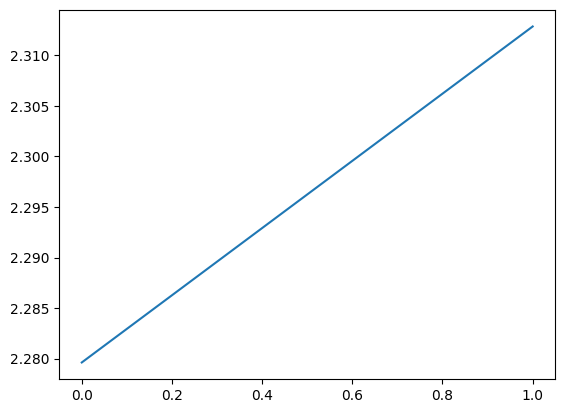

In [15]:
print(losses)
plt.plot(losses)